# Important note before running this code
This code assumes that the data preperation notebook was executed before and hence the sql database accessed underneath, is already populated

In [1]:
# Imports
from sqlalchemy import create_engine, inspect, Table
import pandas as pd
import numpy as np
import json
import country_converter as coco
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
# Open a connection to the postgresql database
db_conn = create_engine("postgresql://student:infomdss@db_dashboard:5432/covid")

In [3]:
print(pd.read_sql('SELECT * FROM cases',db_conn))

     iso_code       date  new_cases_per_million  \
0         ITA 2020-01-31                  0.034   
1         ITA 2020-02-01                  0.000   
2         ITA 2020-02-02                  0.000   
3         ITA 2020-02-03                  0.000   
4         ITA 2020-02-04                  0.000   
...       ...        ...                    ...   
2956      NLD 2022-10-15                  0.000   
2957      NLD 2022-10-16                  0.000   
2958      NLD 2022-10-17                  1.828   
2959      NLD 2022-10-18                665.136   
2960      NLD 2022-10-19                    NaN   

      new_cases_smoothed_per_million  reproduction_rate  
0                                NaN                NaN  
1                                NaN                NaN  
2                                NaN                NaN  
3                                NaN                NaN  
4                                NaN                NaN  
...                              ...   

In [4]:
class Analytics:
    """
    A class designed to perform descriptive analytics for the relation between
    all kpi's and our independent variable, being the public event restrictions (PER) level
    in place (an ordinal value with 5 levels).
    """
    def __init__(self, db_conn,mainView,ISO_filter = ['NLD','JPN','ITA']):
        self.db_conn = db_conn
        self.mainView = mainView
        self.ISO_filter = ISO_filter
    def KPI_policy_covar(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to find and return the covariance matrix between a given kpi and the PER level X days later,
        where X = daysAhead
        NOTE TO SELF: covariance between an ordinal and ratio value might not make sense, might need to delete this function
        """
        kpi, policy = self.__formatColumns(kpiColName,policyColName,daysAhead)
        covar = np.cov(kpi,policy)
        return covar
    def KPI_policy_rho(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to find and return Spearman's rank correlation coefficient, denoted as rho, 
        together with the corresponding p-value between given KPI measure and the PER level X days later, where X = daysAhead.
        """
        kpi , policy = self.__formatColumns(kpiColName,policyColName,daysAhead)
        rho, p = spearmanr(kpi,policy)
        return (rho,p)
    
    def KPI_policy_plot(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to plot the PER level against a given kpi X days earlier, where X = daysAhead, distinguishing between different countries.
        """
        isoDict = self.__getIsoDict(kpiColName,policyColName,daysAhead)
        for iso, v in isoDict.items():
            kpi, policy = v
            plt.scatter(kpi,policy, marker = '.',alpha=0.2)
        plt.xlabel(kpiColName)
        plt.ylabel(policyColName)
        title = policyColName + ' for ' + kpiColName + ' ' + str(daysAhead) +' days before in '
        if len(self.ISO_filter)==1:
            title += self.ISO_filter[0]
        else:
            for iso in self.ISO_filter[:-1]:
                title+= iso + ', '
            title = title[:-2]
            title += ' and ' + self.ISO_filter[-1]
        plt.title(title)
        leg = [x + ' (N=' + str(len(isoDict[x][0])) + ')' for x in isoDict.keys()]
        plt.legend(leg)
        plt.yticks(np.arange(5),['No restrictions','> 1000 people','100-1000 people','10-100 people','< 10 people'])
        plt.show()

    def KPIs_policy_stats_and_plots(self, kpiColNameList, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method which provides and prints statistical data on the relation between a given list of KPIs and the PER level X days later, where X = daysAhead
        and plots their relation as well
        """
        for kpiName in kpiColNameList:
            print(kpiName)
            print('covariation:\n'+str(self.KPI_policy_covar(kpiName,policyColName,daysAhead)))
            rho, p = self.KPI_policy_rho(kpiName,policyColName,daysAhead)
            print('Pearson Rho: ' + str(rho) +'\t' + 'p: ' + str(p))
            self.KPI_policy_plot(kpiName,policyColName,daysAhead)
    def __getIsoDict(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method which reads a KPI from the SQL database for all countries specified in the ISO_filter distinctly.
        And makes them of equal length such that the Nth entry of the KPI array is the value of this KPI X days before
        the PER level of the Nth entry of the policy array, where X = daysAhead.
        The method returns a dictionary mapping the ISO code of each country to a (kpi, policy) pair for that country.
        """
        isoDict = dict()
        for iso in self.ISO_filter:
            queryP2 = ' FROM ' + self.mainView + '\nWHERE ' "iso_code = '" + iso + "';"
            kpi = np.array(pd.read_sql('SELECT ' + kpiColName + queryP2, self.db_conn)[kpiColName])
            policy = np.array(pd.read_sql('SELECT ' + policyColName + queryP2, self.db_conn)[policyColName])
            #making kpi and policy columns of equal length such that for each i kpi[i] is the value of this kpi...
            #... N days before the policy level was at policy[i], where N = daysAhead.
            policy = policy[daysAhead:]
            kpi = kpi[:-daysAhead]
            toDelete = []

            for i in range(len(policy)):
                if policy[i] == None or kpi[i] == None or np.isnan(policy[i]) or np.isnan(kpi[i]): #Ugly code, first 2 conditions should be dropped after data preprocessing makes sure missing values are encoded consistently
                    toDelete.append(i)
            kpi = np.delete(kpi,toDelete)
            policy = np.delete(policy,toDelete)
            isoDict[iso] = (kpi,policy)
        return isoDict
    
    def __formatColumns(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method which returns a kpi, policy pair of equal length such that the Nth entry of the KPI array is the value of this KPI X days before
        the PER level of the Nth entry of the policy array, where X = daysAhead. These arrays contain the values for all countries in the ISO_filter.
        """
        isoDict = self.__getIsoDict(kpiColName,policyColName,daysAhead)
        
        kpi = []
        policy = []
        for k, v in isoDict.items():
            kpiPart, policyPart = v
            kpi.extend(kpiPart)
            policy.extend(policyPart)
        return kpi, policy
    
    

In [5]:
analytics = Analytics(db_conn,'all_relevant')

In [6]:
analytics.KPI_policy_rho('reproduction_rate')

(0.0632440051910639, 0.0007584955963373388)

In [7]:
kpis = ['new_cases_smoothed_per_million','reproduction_rate','icu_patients_per_million','hosp_patients_per_million','weekly_icu_admissions_per_million',
        'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred','new_vaccinations_smoothed_per_million']

new_cases_smoothed_per_million
covariation:
[[ 4.70752476e+05 -8.35313692e+01]
 [-8.35313692e+01  2.62105994e+00]]
Pearson Rho: 0.11038757979872434	p: 2.8932629882402893e-09


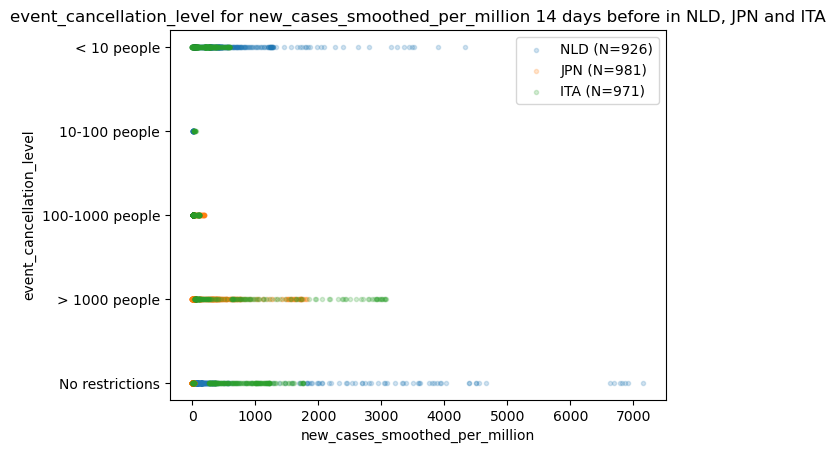

reproduction_rate
covariation:
[[0.14863139 0.03918488]
 [0.03918488 2.60051648]]
Pearson Rho: 0.0632440051910639	p: 0.0007584955963373388


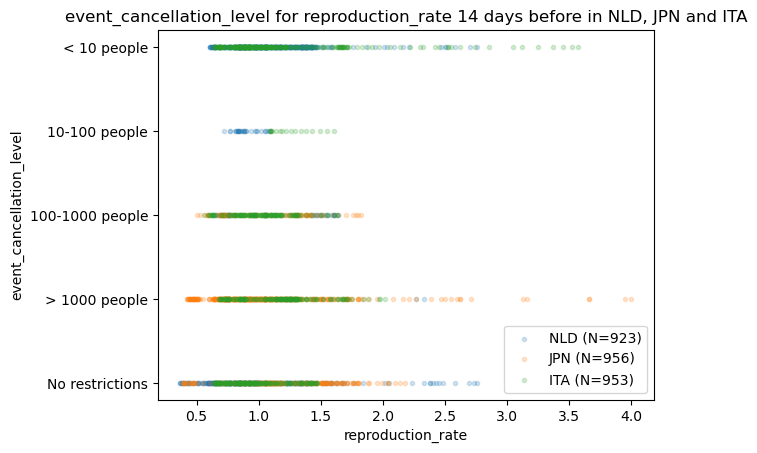

icu_patients_per_million
covariation:
[[322.01431312  20.14562635]
 [ 20.14562635   3.00435381]]
Pearson Rho: 0.5768994227857394	p: 3.317677230390039e-174


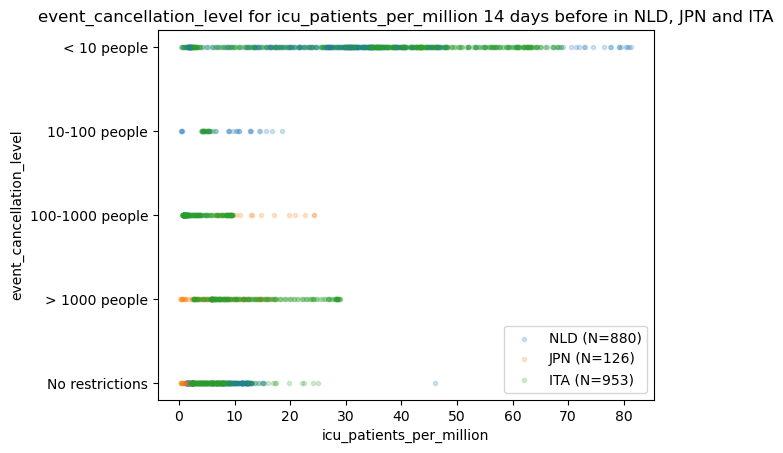

hosp_patients_per_million
covariation:
[[2.03089551e+04 8.06431068e+01]
 [8.06431068e+01 3.00510985e+00]]
Pearson Rho: 0.25017442488900066	p: 2.3702224848594802e-29


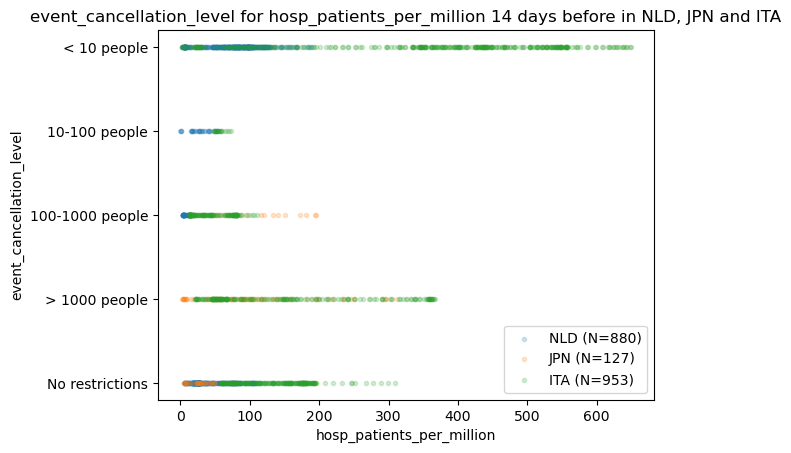

weekly_icu_admissions_per_million
covariation:
[[50.11968071  9.10312366]
 [ 9.10312366  3.35095386]]
Pearson Rho: 0.672338468674905	p: 1.248916346303744e-171


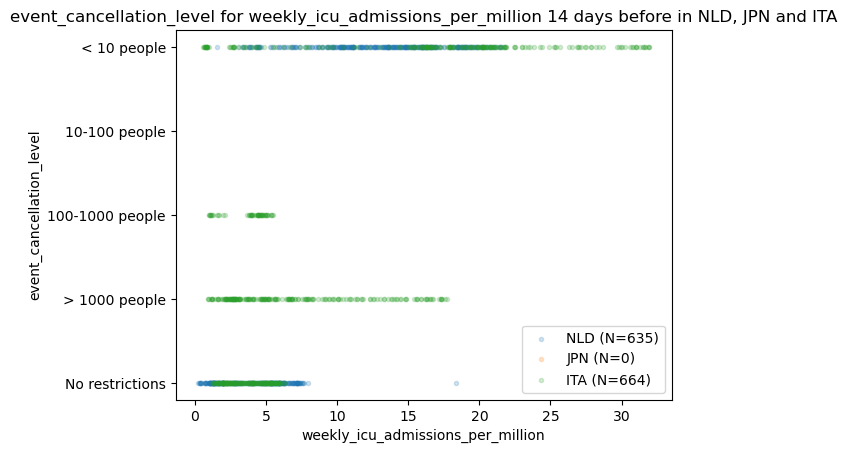

people_fully_vaccinated_per_hundred
covariation:
[[941.62598634 -28.33350653]
 [-28.33350653   1.62739409]]
Pearson Rho: -0.6483620086953252	p: 2.996093917373702e-154


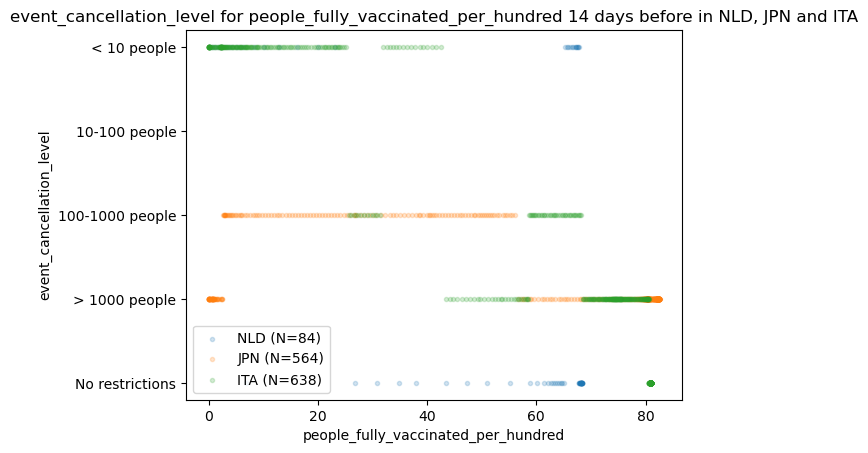

total_boosters_per_hundred
covariation:
[[ 8.28522456e+02 -8.07214422e+00]
 [-8.07214422e+00  4.29651778e-01]]
Pearson Rho: -0.5115261989304688	p: 1.0274167099597052e-50


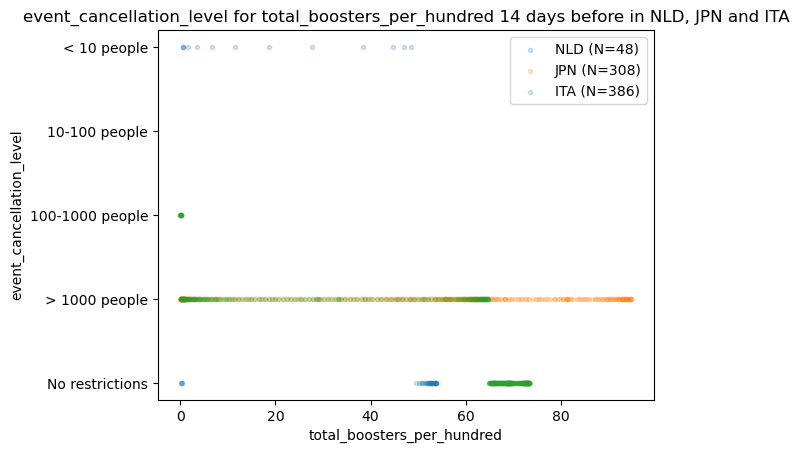

new_vaccinations_smoothed_per_million
covariation:
[[1.27784669e+07 1.59136413e+03]
 [1.59136413e+03 2.26860815e+00]]
Pearson Rho: 0.4598390088987887	p: 5.490631079865911e-97


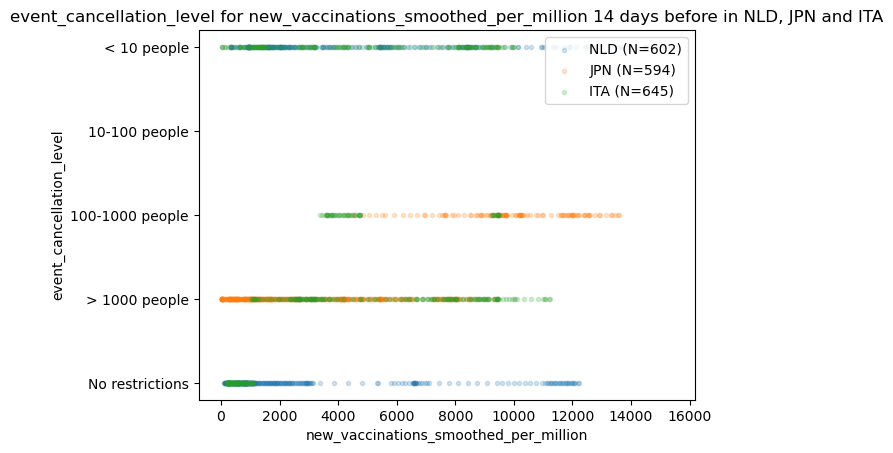

In [8]:

analytics.KPIs_policy_stats_and_plots(kpis)

In [9]:
analytics.KPI_policy_covar('new_cases_smoothed_per_million')

array([[ 4.70752476e+05, -8.35313692e+01],
       [-8.35313692e+01,  2.62105994e+00]])

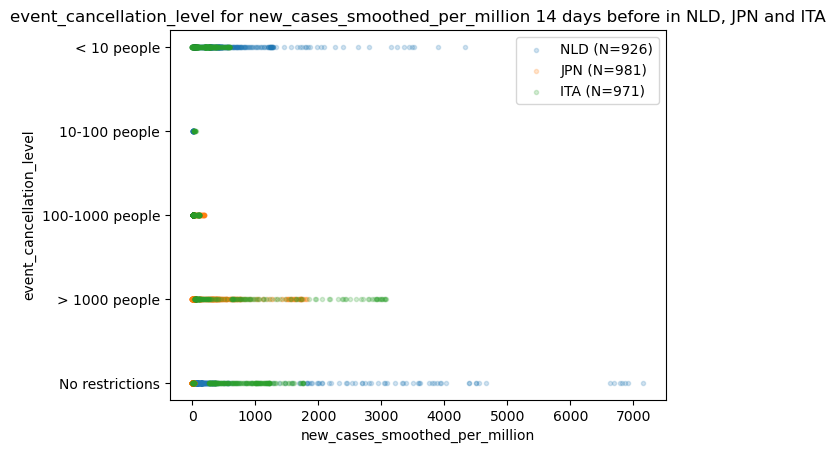

In [10]:
analytics.KPI_policy_plot('new_cases_smoothed_per_million',daysAhead=14)